# 联邦学习简单实现 —— FedAvg 算法

本 Notebook 实现了一个简单的联邦学习示例。我们将使用 MNIST 数据集，将训练数据分成多个客户端，每个客户端在本地训练一个简单的神经网络（MLP），然后采用 FedAvg 算法对各客户端的模型参数进行平均聚合，更新全局模型。整个过程分为数据加载与划分、模型定义、局部训练、模型聚合和全局评估等步骤。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 超参数设置
num_clients = 5        # 客户端数量
local_epochs = 1       # 每个客户端本地训练的轮数
batch_size = 32        # 批次大小
num_rounds = 20         # 联邦学习的通信轮数
device = "cuda:0" if torch.cuda.is_available() else "cpu"
n_classes = 10

/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 数据加载与客户端数据划分
我们使用 MNIST 数据集，并将训练数据均匀划分给多个客户端。每个客户端拥有自己独立的数据子集。

In [2]:
# 数据预处理：将图片转换为 tensor 并归一化
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# 下载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 将训练集均分给各个客户端（这里简单采用均分的方式）
#client_data_sizes = [len(train_dataset) // num_clients] * num_clients
#client_datasets = random_split(train_dataset, client_data_sizes)
#client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_datasets]


## 使用指定类别映射的非 IID 数据划分（每个客户端拥有两个 class 的全部数据）
在本方法中，我们根据预先定义的客户端-类别映射，将数据集中的样本直接分配给对应客户端，例如：Client 0 获得类别 0 和 1 的所有数据，Client 1 获得类别 2 和 3 的所有数据，以此类推。这种划分方式可用于模拟客户端数据在类别上完全不重叠的情况。

Client 0 拥有类别 [0, 1]，数据量: 12665
Client 1 拥有类别 [2, 3]，数据量: 12089
Client 2 拥有类别 [4, 5]，数据量: 11263
Client 3 拥有类别 [6, 7]，数据量: 12183
Client 4 拥有类别 [8, 9]，数据量: 11800


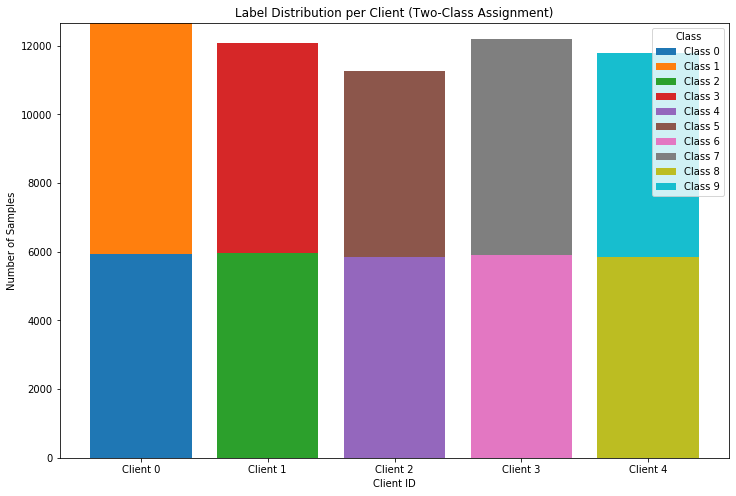

In [3]:
import numpy as np
import torch
from torch.utils.data import Subset
import matplotlib.pyplot as plt

# 固定随机种子（如有需要，可在需要随机操作的地方使用）
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# MNIST 有 10 个类别，假设我们想要将它们两两分配给 5 个客户端
client_class_map = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9]
}

# 1. 根据映射为每个客户端筛选对应类别的数据
client_subsets = []
for client_id, classes in client_class_map.items():
    # 如果 train_dataset.targets 是 Tensor，则先转换为 numpy
    targets = train_dataset.targets.numpy() if isinstance(train_dataset.targets, torch.Tensor) else train_dataset.targets
    
    # np.isin(targets, classes) 返回布尔数组，True 表示标签在 classes 中
    indices = np.where(np.isin(targets, classes))[0].tolist()
    
    subset = Subset(train_dataset, indices)
    client_subsets.append(subset)
    print(f"Client {client_id} 拥有类别 {classes}，数据量: {len(indices)}")

# 2. 可视化每个客户端中的类别分布
client_datasets = client_subsets
client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_datasets]

n_clients = len(client_subsets)
n_classes = 10  # MNIST 有 10 个类别
client_class_counts = []

# 遍历每个客户端的 Subset
for subset in client_subsets:
    # 当前客户端对应的数据索引
    indices = subset.indices
    # 只拿到该客户端的标签
    targets = train_dataset.targets.numpy() if isinstance(train_dataset.targets, torch.Tensor) else train_dataset.targets
    labels = targets[indices]
    
    # 统计每个类别出现的次数
    counts = [np.sum(labels == i) for i in range(n_classes)]
    client_class_counts.append(counts)

client_class_counts = np.array(client_class_counts)  # shape: (n_clients, n_classes)

# 3. 堆叠柱状图展示
plt.figure(figsize=(12, 8))
client_ids = np.arange(n_clients)
bottom = np.zeros(n_clients)
colors = plt.cm.tab10.colors  # 10 种颜色

for cls in range(n_classes):
    plt.bar(client_ids, client_class_counts[:, cls], bottom=bottom, 
            color=colors[cls], label=f"Class {cls}")
    bottom += client_class_counts[:, cls]

plt.xlabel("Client ID")
plt.ylabel("Number of Samples")
plt.title("Label Distribution per Client (Two-Class Assignment)")
plt.xticks(client_ids, [f"Client {i}" for i in range(n_clients)])
plt.legend(title="Class")
plt.show()


## 定义模型
这里我们定义一个简单的全连接神经网络（MLP），用于 MNIST 手写数字分类。模型由一个隐藏层构成。

In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # 将 28x28 的图像展平为 784 维向量
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## 局部训练函数
定义每个客户端的本地训练过程。每个客户端在自己的数据上训练若干个 epoch，并返回训练后的模型参数。

In [5]:
def local_train(model, dataloader, epochs, device):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    # 返回训练后的模型参数
    return model.state_dict()


## FedAvg 聚合函数（数据量加权）

在实际应用中，各客户端的数据量可能不一致，因此在聚合时需要根据每个客户端的数据量进行加权：
$$
\theta_{global} = \sum_i \frac{n_i}{N_{total}} \theta_i
$$
其中$ n_i $是客户端$ i $的数据量，$ N_{total} $是所有客户端数据量之和。


In [6]:
def fed_avg(global_model, client_state_dicts, client_data_counts):
    global_state_dict = global_model.state_dict()
    # 初始化全局模型参数为零
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.zeros_like(global_state_dict[key])
    total_samples = sum(client_data_counts)
    # 对每个客户端的参数按数据量权重累加
    for client_state, n_samples in zip(client_state_dicts, client_data_counts):
        weight = n_samples / total_samples
        for key in global_state_dict.keys():
            global_state_dict[key] += client_state[key] * weight
    # 更新全局模型
    global_model.load_state_dict(global_state_dict)
    return global_model


## 联邦学习主流程及每轮局部模型测试
在每一轮全局通信中，我们让每个客户端先在自己的本地训练后：
- 使用其本地模型在整个测试集上进行评估（计算总体准确率和各类别准确率）。
- 最后，将所有客户端的模型按照各自数据量的权重使用 FedAvg 进行聚合，形成更新后的全局模型。

这样可以帮助我们观察每个客户端在局部训练后的性能，同时也能追踪全局模型在聚合后的表现。

In [7]:
def evaluate_model(model, device, test_loader, n_classes=10):
    """
    在测试集上评估给定模型的表现，返回总体准确率及各类别准确率。
    """
    model.eval()
    correct = 0
    total = 0
    class_correct = [0 for _ in range(n_classes)]
    class_total = [0 for _ in range(n_classes)]
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for i in range(target.size(0)):
                label = target[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
                    
    overall_accuracy = 100.0 * correct / total
    class_accuracies = [100.0 * c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    return overall_accuracy, class_accuracies

# 定义测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 联邦学习主流程（使用数据量加权的 FedAvg）
这里首先计算每个客户端的数据量，然后在每一轮通信中：

- 将全局模型下发到各客户端进行本地训练；
- 收集各客户端更新后的模型参数；
- 使用上述加权 FedAvg 方法聚合各客户端模型参数，更新全局模型。

In [8]:
# 计算每个客户端数据量
client_data_counts = [len(dataset) for dataset in client_datasets]
print("每个客户端数据量:", client_data_counts)

global_model = SimpleNN().to(device)


for r in range(num_rounds):
    print(f"==== 第 {r+1} 轮通信 ====")
    client_state_dicts = []
    local_models = []
    
    # 遍历每个客户端，进行本地训练和测试
    for c_id, client_loader in enumerate(client_loaders):
        local_model = SimpleNN().to(device)
        # 同步全局模型参数到客户端
        local_model.load_state_dict(global_model.state_dict())
        # 客户端本地训练
        local_state = local_train(local_model, client_loader, local_epochs, device)
        client_state_dicts.append(local_state)
        local_models.append(local_model)
        
        # 测试当前客户端本地模型在整个测试集上的表现
        overall_acc, class_acc = evaluate_model(local_model, device, test_loader, n_classes)
        print(f"Client {c_id} local model test accuracy: {overall_acc:.2f}%")
        for i in range(n_classes):
            print(f"  Class {i} accuracy: {class_acc[i]:.2f}%")
    
    # 使用数据量加权的 FedAvg 聚合各客户端模型
    global_model = fed_avg(global_model, client_state_dicts, client_data_counts)
    
    # 选择性：测试聚合后的全局模型
    global_acc, global_class_acc = evaluate_model(global_model, device, test_loader, n_classes)
    print(f"Global model after round {r+1} test accuracy: {global_acc:.2f}%")
    for i in range(n_classes):
        print(f"  Global model Class {i} accuracy: {global_class_acc[i]:.2f}%")
    print("\n")


每个客户端数据量: [12665, 12089, 11263, 12183, 11800]
==== 第 1 轮通信 ====
Client 0 local model test accuracy: 21.13%
  Class 0 accuracy: 99.80%
  Class 1 accuracy: 100.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 1 local model test accuracy: 19.92%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 97.19%
  Class 3 accuracy: 97.92%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 2 local model test accuracy: 18.54%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 99.29%
  Class 5 accuracy: 98.54%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 3 local model